table of contents
1. 準備
2. データのインポート
3. ボール奪取ヒートマップ
4. プレイパターン

# 準備

In [1]:
import os, itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)

In [2]:
COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.edgecolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

twitter_color = '#141d26'

# データのインポート

In [3]:
base_dir = os.path.join('..','..')
data_dir = os.path.join(base_dir, 'data', 'raw')

def read_dfs():
    players_df = pd.read_json(os.path.join(data_dir, 'players.json'))
    teams_df = pd.read_json(os.path.join(data_dir, 'teams.json'))

    # encode, decode
    players_df['shortName'] = players_df.shortName.apply(lambda x: x.encode('utf-8').decode('unicode-escape'))
    teams_df['name'] = teams_df.name.apply(lambda x: x.encode('utf-8').decode('unicode-escape'))

    return players_df, teams_df

players_df, teams_df = read_dfs()

competition_list = [infile.replace('matches_','').replace('.json','') for infile in os.listdir(os.path.join(data_dir, 'matches')) if infile.endswith('.json')]

print(competition_list)

['World_Cup', 'Italy', 'Germany', 'England', 'France', 'Spain', 'European_Championship']


In [4]:
selected_competition = 'Spain'

def read_events_df(selected_competition):
    events_df = pd.read_json(os.path.join(data_dir, 'events', f'events_{selected_competition}.json'))
    return events_df

def read_matches_df(selected_competition):
    matches_df = pd.read_json(os.path.join(data_dir, 'matches', f'matches_{selected_competition}.json'))
    matches_df['date_time'] = pd.to_datetime(matches_df.dateutc)

    # encode, decode
    matches_df['label'] = matches_df.label.apply(lambda x: x.encode('utf-8').decode('unicode-escape'))
    matches_df['venue'] = matches_df.venue.apply(lambda x: x.encode('utf-8').decode('unicode-escape'))

    # concate label, venue, date_time
    matches_df['name'] = matches_df[['label', 'venue', 'date_time']].apply(lambda xs: f'{xs[0]} @{xs[1]}, {xs[2].date()}', axis=1)

    c_list = ['home_team_name', 'away_team_name', 'home_team_score', 'away_team_score']
    for c in c_list:
        matches_df[c] = np.zeros(len(matches_df))
    matches_df[c_list] = [list(itertools.chain.from_iterable([v.split(' @')[0].split(' - ') for v in name.split(', ')[:2]])) for name in matches_df.name.tolist()]

    return matches_df.sort_values('date_time')

matches_df = read_matches_df(selected_competition)

name_list = matches_df.name.tolist()

In [5]:
# selected_match = 'Germany - France, 0 - 2 @Stade Vélodrome, 2016-07-07'
# selected_wyId = matches_df[matches_df.name == selected_match].wyId.values[0]

events_df = read_events_df(selected_competition)

matchPeriod_list = ['1H', '2H']

# df_tmp = events_df[(events_df.matchId == selected_wyId)&(events_df.eventName=='Shot')&(events_df.matchPeriod.isin(matchPeriod_list))]

# ボール奪取マップ

In [6]:
events_df.eventName.unique()

array(['Pass', 'Duel', 'Others on the ball', 'Shot', 'Save attempt',
       'Interruption', 'Free Kick', 'Foul', 'Offside',
       'Goalkeeper leaving line'], dtype=object)

## デュエル

In [7]:
events_df[events_df.eventName=='Duel'].subEventName.unique()

array(['Ground defending duel', 'Ground attacking duel',
       'Ground loose ball duel', 'Air duel'], dtype=object)

In [8]:
flg_df = events_df[events_df.eventName=='Duel'].tags.apply(lambda x_list: 702 in [x_dict['id'] for x_dict in x_list]).reset_index()

In [9]:
events_df.iloc[flg_df[flg_df['tags']==True]['index'], :]

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
128,1,Ground defending duel,"[{'id': 702}, {'id': 1801}]",255738,"[{'y': 6, 'x': 9}, {'y': 16, 'x': 30}]",2565548,Duel,695,1H,555.879039,12,180864676
155,1,Ground attacking duel,"[{'id': 503}, {'id': 702}, {'id': 1801}]",225089,"[{'y': 22, 'x': 89}, {'y': 0, 'x': 100}]",2565548,Duel,695,1H,622.391751,11,180864707
156,1,Ground defending duel,"[{'id': 504}, {'id': 702}, {'id': 1801}]",15214,"[{'y': 78, 'x': 11}, {'y': 100, 'x': 0}]",2565548,Duel,682,1H,623.494728,12,180864513
193,1,Ground defending duel,"[{'id': 702}, {'id': 1801}]",225089,"[{'y': 86, 'x': 94}, {'y': 0, 'x': 0}]",2565548,Duel,695,1H,807.478844,12,180864743
194,1,Ground attacking duel,"[{'id': 702}, {'id': 1801}]",3534,"[{'y': 14, 'x': 6}, {'y': 100, 'x': 100}]",2565548,Duel,682,1H,808.240876,11,180864536
...,...,...,...,...,...,...,...,...,...,...,...,...
628547,1,Ground attacking duel,"[{'id': 702}, {'id': 1801}]",69404,"[{'y': 73, 'x': 40}, {'y': 100, 'x': 37}]",2565927,Duel,675,2H,2514.796720,11,253302571
628609,1,Ground attacking duel,"[{'id': 702}, {'id': 1801}]",134174,"[{'y': 92, 'x': 41}, {'y': 100, 'x': 42}]",2565927,Duel,682,2H,2757.014461,11,253302618
628610,1,Ground defending duel,"[{'id': 702}, {'id': 1801}]",3321,"[{'y': 8, 'x': 59}, {'y': 0, 'x': 58}]",2565927,Duel,675,2H,2757.509570,12,253302660
628619,1,Ground attacking duel,"[{'id': 503}, {'id': 702}, {'id': 1801}]",20623,"[{'y': 93, 'x': 42}, {'y': 100, 'x': 46}]",2565927,Duel,682,2H,2792.578670,11,253302631


## インターセプト（そのお明日も成功）

In [10]:
events_df[events_df.eventName=='Pass'].head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],3542,"[{'y': 61, 'x': 37}, {'y': 50, 'x': 50}]",2565548,Pass,682,1H,2.994582,85,180864419
1,8,Simple pass,[{'id': 1801}],274435,"[{'y': 50, 'x': 50}, {'y': 30, 'x': 45}]",2565548,Pass,682,1H,3.137020,85,180864418
2,8,Simple pass,[{'id': 1801}],364860,"[{'y': 30, 'x': 45}, {'y': 12, 'x': 38}]",2565548,Pass,682,1H,6.709668,85,180864420
3,8,Simple pass,[{'id': 1801}],3534,"[{'y': 12, 'x': 38}, {'y': 69, 'x': 32}]",2565548,Pass,682,1H,8.805497,85,180864421
4,8,Simple pass,[{'id': 1801}],3695,"[{'y': 69, 'x': 32}, {'y': 37, 'x': 31}]",2565548,Pass,682,1H,14.047492,85,180864422


In [11]:
events_df[events_df.eventName=='Pass'].subEventName.unique()

array(['Simple pass', 'Smart pass', 'Cross', 'High pass', 'Head pass',
       'Launch', 'Hand pass'], dtype=object)

In [12]:
flg_df = events_df[events_df.eventName=='Pass'].tags.apply(lambda x_list: (1401 in [x_dict['id'] for x_dict in x_list])and(1801 in [x_dict['id'] for x_dict in x_list])).reset_index()

In [13]:
events_df.iloc[flg_df[flg_df['tags']==True]['index'],:]

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
13,8,Simple pass,"[{'id': 1401}, {'id': 1801}]",3496,"[{'y': 44, 'x': 9}, {'y': 5, 'x': 24}]",2565548,Pass,695,1H,42.500082,85,180864539
44,8,Head pass,"[{'id': 1401}, {'id': 1801}]",3919,"[{'y': 58, 'x': 26}, {'y': 62, 'x': 11}]",2565548,Pass,695,1H,184.283154,82,180864578
59,8,Head pass,"[{'id': 1401}, {'id': 1801}]",364860,"[{'y': 16, 'x': 25}, {'y': 25, 'x': 26}]",2565548,Pass,682,1H,277.248966,82,180864461
62,8,Simple pass,"[{'id': 1401}, {'id': 1801}]",3919,"[{'y': 82, 'x': 60}, {'y': 83, 'x': 73}]",2565548,Pass,695,1H,281.894038,85,180864594
83,8,Simple pass,"[{'id': 1401}, {'id': 1801}]",3277,"[{'y': 47, 'x': 30}, {'y': 41, 'x': 34}]",2565548,Pass,682,1H,352.932537,85,180864473
...,...,...,...,...,...,...,...,...,...,...,...,...
628013,8,Simple pass,"[{'id': 1401}, {'id': 1801}]",4501,"[{'y': 96, 'x': 58}, {'y': 96, 'x': 68}]",2565927,Pass,675,2H,882.089259,85,253301900
628219,8,Simple pass,"[{'id': 1401}, {'id': 1801}]",20623,"[{'y': 71, 'x': 64}, {'y': 68, 'x': 63}]",2565927,Pass,682,2H,1454.346592,85,253302184
628356,8,Head pass,"[{'id': 1401}, {'id': 1801}]",20393,"[{'y': 55, 'x': 22}, {'y': 65, 'x': 35}]",2565927,Pass,682,2H,1918.456218,82,253302302
628461,8,Simple pass,"[{'id': 1401}, {'id': 1801}]",3306,"[{'y': 37, 'x': 22}, {'y': 26, 'x': 30}]",2565927,Pass,675,2H,2196.287886,85,253302477


## 上記データをunion

In [14]:
flg_duel_df = events_df[events_df.eventName=='Duel'].tags.apply(lambda x_list: 702 in [x_dict['id'] for x_dict in x_list]).reset_index()

flg_pass_df = events_df[events_df.eventName=='Pass'].tags.apply(lambda x_list: (1401 in [x_dict['id'] for x_dict in x_list])and(1801 in [x_dict['id'] for x_dict in x_list])).reset_index()

events_df_tmp = pd.concat([events_df.iloc[flg_duel_df[flg_duel_df['tags']==True]['index'], :], events_df.iloc[flg_pass_df[flg_pass_df['tags']==True]['index'],:]])

In [15]:
len(events_df_tmp)

47979

In [16]:
teamId = events_df_tmp.teamId.unique().tolist()[6]
teamName = teams_df[teams_df.wyId==teamId].name.values[0]
print(teamName)

Atlético Madrid


In [17]:
print(len(events_df_tmp[events_df_tmp.teamId==teamId].matchId.unique().tolist()))

38


In [18]:
XMAX, XMIN = 120, 0
YMAX, YMIN = 80, 0

events_df_tmp[['x', 'y']] =  events_df_tmp.apply(lambda xs: [XMAX*xs['positions'][0]['x']/100, YMAX*(1-xs['positions'][0]['y']/100)], result_type='expand', axis=1)

In [24]:
pd.set_option("max_colwidth", 100)

In [32]:
ball_hunt_summary = pd.merge(events_df_tmp[events_df_tmp.teamId==teamId].groupby('matchId')[['x']].mean().reset_index(), matches_df[['wyId', 'name']], left_on='matchId', right_on='wyId')[['x', 'name']].sort_values(by='x').reset_index(drop=True)
ball_hunt_summary.index = ball_hunt_summary.index + 1
display(ball_hunt_summary)

,x,name
1,41.970370,"Eibar - Atlético Madrid, 0 - 1 @Estadio Municipal de Ipurúa, 2018-01-13"
2,44.980645,"Villarreal - Atlético Madrid, 2 - 1 @Estadio de la Cerámica, 2018-03-18"
3,45.978947,"Atlético Madrid - Real Madrid, 0 - 0 @Estadio Wanda Metropolitano, 2017-11-18"
4,47.617391,"Atlético Madrid - Barcelona, 1 - 1 @Estadio Wanda Metropolitano, 2017-10-14"
5,48.152727,"Levante - Atlético Madrid, 0 - 5 @Estadio Ciudad de Valencia, 2017-11-25"
6,48.600000,"Real Madrid - Atlético Madrid, 1 - 1 @Estadio Santiago Bernabéu, 2018-04-08"
7,49.242857,"Atlético Madrid - Eibar, 2 - 2 @Estadio Wanda Metropolitano, 2018-05-20"
8,49.650000,"Athletic Club - Atlético Madrid, 1 - 2 @San Mamés Barria, 2017-09-20"
9,49.685714,"Real Betis - Atlético Madrid, 0 - 1 @Estadio Benito Villamarín, 2017-12-10"
10,49.856250,"Málaga - Atlético Madrid, 0 - 1 @Estadio La Rosaleda, 2018-02-10"


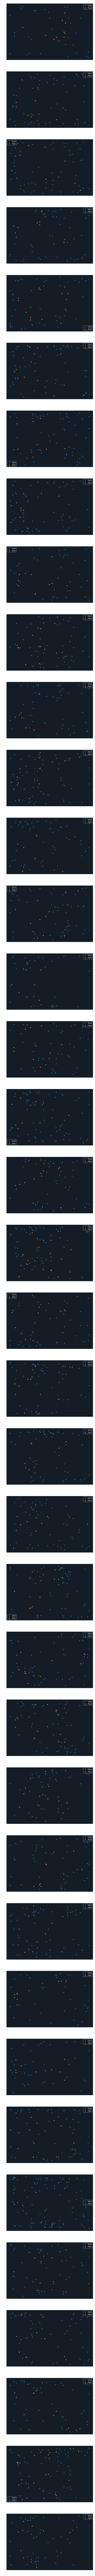

In [56]:
cmap = plt.get_cmap('tab10')
matchId_list = events_df_tmp[events_df_tmp.teamId==teamId].matchId.unique().tolist()

fig, axes = plt.subplots(nrows=len(matchId_list), ncols=1, figsize=(10, 8*len(matchId_list)))

for i, matchId in enumerate(matchId_list):
    ax = axes[i]
    title = matches_df[matches_df.wyId==matchId].name.values[0]
    ax.set_title(title)
    for j, eventName in enumerate(events_df_tmp[(events_df_tmp.matchId==matchId)&(events_df_tmp.teamId==teamId)].eventName.unique().tolist()):
        events_df_tmp[(events_df_tmp.matchId==matchId)&(events_df_tmp.teamId==teamId)&(events_df_tmp.eventName==eventName)].plot.scatter(x='x', y='y', label=eventName, color=cmap(j), ax=ax)
    ax.set_facecolor(twitter_color); ax.legend(facecolor=twitter_color)

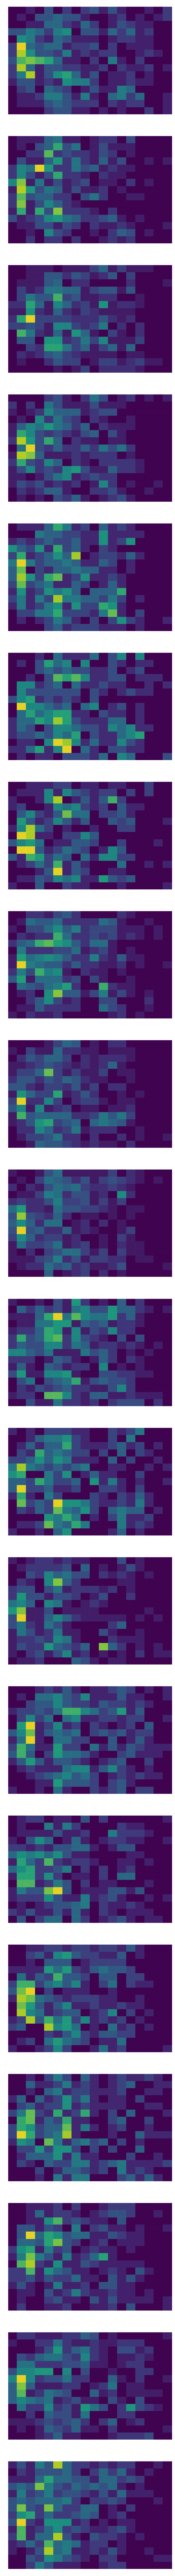

In [74]:
# import matplotlib
teamId_list = events_df_tmp.teamId.unique().tolist()
fig, axes = plt.subplots(nrows=len(teamId_list), ncols=1, figsize=(10, 8*len(teamId_list)))

for i, teamId in enumerate(teamId_list):
    ax = axes[i]
    name = teams_df[teams_df.wyId==teamId].name.values[0]
    ax.set_title(name)
    df_tmp = events_df_tmp[(events_df_tmp.teamId==teamId)&(events_df_tmp.eventName==eventName)]
#     ax.hist2d(df_tmp.x.values, df_tmp.y.values, bins=[20, 18], cmap=matplotlib.cm.bone, alpha=0.9)
    ax.hist2d(df_tmp.x.values, df_tmp.y.values, bins=[18, 15], alpha=0.9)
    ax.set_facecolor(twitter_color)

# プレイパターン